In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import numpy as np
import os
import math

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import random
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from google.colab import drive
drive.mount('/content/drive')
animal_path = '/content/drive/My Drive/animals/'  # change this !!!!

Mounted at /content/drive


# Animal Classification

## Load datasets

In [2]:
''' load and preprocess images'''
def load_images(path, size=(128,128)):
  images = []
  labels = []
  subfolders = [f.path for f in os.scandir(path) if f.is_dir()]
  for subfolder in subfolders:
    print(f"Reading images from folder: {subfolder}")

    # Get a list of image files in the subfolder
    image_files = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.endswith(('.jpg', '.jpeg', '.png'))]

    # Iterate through each image file
    for image_file in image_files:
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image,size)
        images.append(image)
        labels.append(subfolder.split('/')[-1])
  return images, labels

animal_train_path = animal_path + 'train/'
animal_test_path = animal_path + 'test/'

animal_train_images, animal_train_label = load_images(animal_train_path)
animal_test_images, animal_test_label = load_images(animal_test_path)

Reading images from folder: /content/drive/My Drive/animals/train/cat
Reading images from folder: /content/drive/My Drive/animals/train/dog
Reading images from folder: /content/drive/My Drive/animals/train/tiger
Reading images from folder: /content/drive/My Drive/animals/train/leopard
Reading images from folder: /content/drive/My Drive/animals/test/tiger
Reading images from folder: /content/drive/My Drive/animals/test/cat
Reading images from folder: /content/drive/My Drive/animals/test/dog
Reading images from folder: /content/drive/My Drive/animals/test/leopard


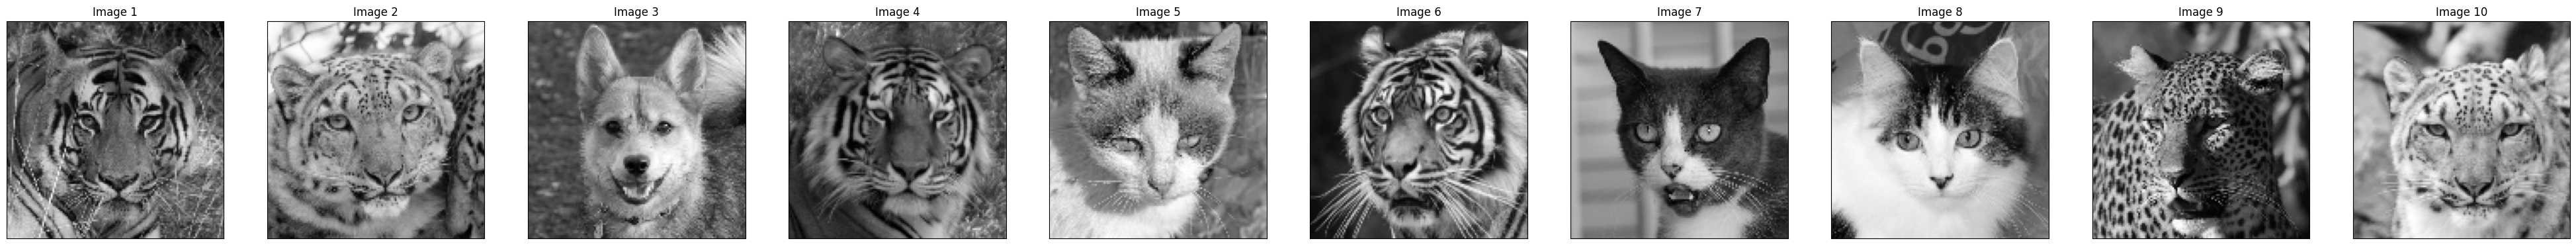

In [3]:
'''Show some images in this dataset'''
indices = random.sample(range(len(animal_train_images)), 10)
plt.figure(figsize=(50,500))
for i in range(10):
  img = animal_train_images[indices[i]]
  plt.subplot(1,10,i+1)
  plt.imshow(img, cmap='gray')
  plt.title(f'Image {i+1}')
  plt.xticks([])
  plt.yticks([])
plt.show()

## PCA

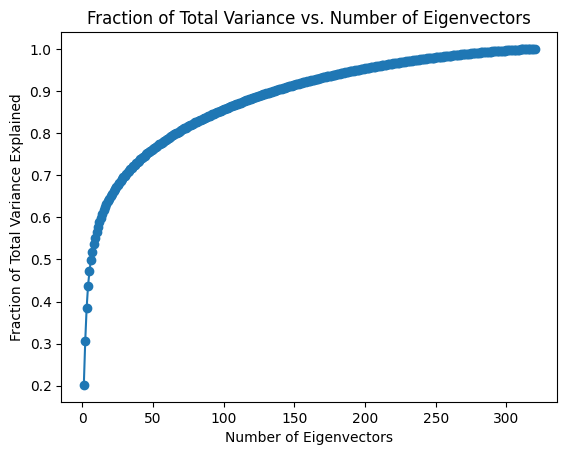

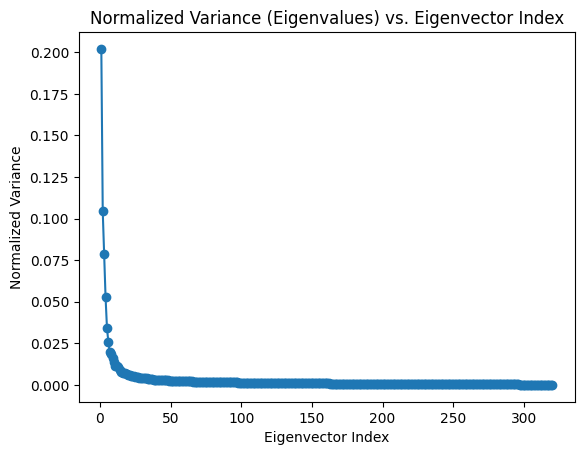

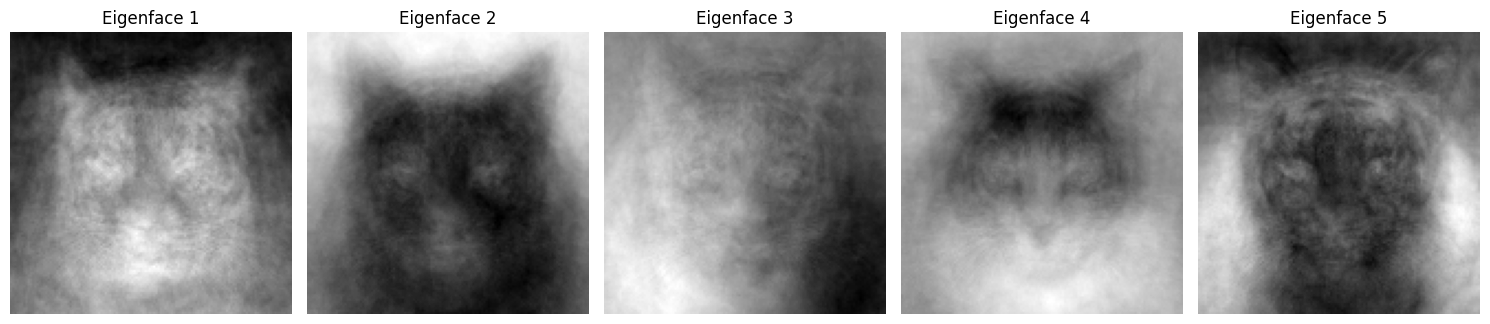

In [4]:
# Function to perform PCA using the Snapshot method
def PCA(images, num_eigenvectors):
  # Flatten images into 1D arrays
  flattened_images = images.reshape(images.shape[0],-1)

  # Calculate the mean face
  mean_face = np.mean(flattened_images, axis=0)

  # Subtract mean face from each image
  DT = flattened_images - mean_face

  # Compute D^T * D
  D = np.transpose(DT)
  DTD = np.matmul(DT,D) # Dt*D

  # Compute eigenvecotrs using the Snapshot method
  eigenvalues, eigenvectorsDTD = np.linalg.eig(DTD)
  eigenvectors = np.matmul(D,eigenvectorsDTD)

  # Sort eigenvectors and eigenvalues in descending order
  sorted_indices = np.argsort(eigenvalues)[::-1]
  eigenvalues = eigenvalues[sorted_indices]
  eigenvectors = eigenvectors[:, sorted_indices]

  # Select the top num_eigenvectors eigenvoectors
  selected_eigenvectors = eigenvectors[:, :num_eigenvectors]

  # Compute the fraction of total variance explained by each eigenvector
  total_variance = np.sum(eigenvalues)
  explained_variance_ratio = eigenvalues / total_variance

  return mean_face, selected_eigenvectors, explained_variance_ratio, eigenvalues

# Plot the Fraction of Total Variance vs. Number of Eigenvectors
def plot_variance_vs_eigenvectors(explained_variance_ratio):
  cumulative_variance_ratio = np.cumsum(explained_variance_ratio) # cumulative sum
  plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
  plt.title('Fraction of Total Variance vs. Number of Eigenvectors')
  plt.xlabel('Number of Eigenvectors')
  plt.ylabel('Fraction of Total Variance Explained')
  plt.show()

# Plot Normalized Variance (Eigenvalues) vs. Eigenvecotr Index
def plot_normalized_variance(eigenvalues):
  normalized_variance = eigenvalues / np.sum(eigenvalues)
  plt.plot(range(1, len(normalized_variance) + 1), normalized_variance, marker='o')
  plt.title('Normalized Variance (Eigenvalues) vs. Eigenvector Index')
  plt.xlabel('Eigenvector Index')
  plt.ylabel('Normalized Variance')
  plt.show()

# Display the First 5 Eigenfaces
def display_eigenfaces(mean_face, eigenvectors, num_eigenfaces=5):
  eigenfaces = eigenvectors[:, :num_eigenfaces]

  plt.figure(figsize=(15, 5))
  for i in range(num_eigenfaces):
      eigenface = eigenfaces[:, i].reshape(mean_face.shape)  # Reshape to match the original image dimensions
      eigenface_image = eigenface.reshape(animal_train_images[0].shape)  # Adjust dimensions based on image size
      plt.subplot(1, num_eigenfaces, i + 1)
      plt.imshow(eigenface_image, cmap='gray')
      plt.title(f'Eigenface {i + 1}')
      plt.axis('off')

  plt.tight_layout()
  plt.show()


'''
Perform PCA using the Snapshot method and Plot the Fraction of Total Variance
vs. Number of Eigenvecotrs
'''
mean_face, selected_eigenvectors, explained_variance_ratio, eigenvalues = PCA(np.array(animal_train_images), 100)

plot_variance_vs_eigenvectors(explained_variance_ratio)

'''Plot Normalized Variance (Eigenvalues) vs. Eigenvector Index'''
plot_normalized_variance(eigenvalues)

'''Display the First 5 Eigenfaces'''
display_eigenfaces(mean_face, selected_eigenvectors, num_eigenfaces=5)

In [5]:
''' Helper function to extract eigenface features '''
def extract_eigenface_features(images, mean_face, selected_eigenvectors):
  flattened_images = images.reshape(images.shape[0],-1)
  centered_images = flattened_images - mean_face
  eigenface_features = np.dot(centered_images, selected_eigenvectors)
  return eigenface_features

# Compute training and testing features
train_features = extract_eigenface_features(np.array(animal_train_images), mean_face, selected_eigenvectors)
test_features = extract_eigenface_features(np.array(animal_test_images), mean_face, selected_eigenvectors)

## Self-implemented KNN

In [6]:
class KNNClassifier:
  """
    K-Nearest Neighbors Classifier.

    Parameters:
    - k (int): Number of neighbors to consider during classification.
  """
  def __init__(self, k=3):
    self.k = k
    self.train_data = None
    self.train_labels = None

  def fit(self, train_data, train_labels):
    self.train_data = train_data
    self.train_labels = train_labels

  def predict(self, test_data):
    predictions = []
    for sample in test_data:
      # Calculate Euclidean distances between the test instance and all training instances
      # print(self.train_data.shape, sample.shape)
      distances = np.linalg.norm(self.train_data - sample, axis=1)

      # Find indices of k nearest neighbors
      nearest_neighbors_indices = np.argsort(distances)[:self.k]

      # Get labels of k nearest neighbors
      nearest_labels = self.train_labels[nearest_neighbors_indices]

      # Perform majority voting to determine the predicted label
      unique_labels, counts = np.unique(nearest_labels, return_counts=True)
      predicted_label = unique_labels[np.argmax(counts)]
      predictions.append(predicted_label)
    return np.array(predictions)

In [7]:
def train(train_features, train_label, k,k_fold):
  ''' Train KNN models using k-fold validation, and return (k_fold/2) models with the highest accuracy during validation'''

  k_fold = k_fold
  kf = StratifiedKFold(n_splits=k_fold,shuffle=True, random_state=1453)

  models = []
  accuracies = []
  train_label = np.array(train_label)
  for train_index, val_index in kf.split(train_features, train_label):
    train_set_x = train_features[train_index]
    train_set_y = train_label[train_index]
    val_set_x = train_features[val_index]
    val_set_y = train_label[val_index]

    knn_classifier = KNNClassifier(k=k)
    models.append(knn_classifier)

    # Train the KNN classifier with the training data
    knn_classifier.fit(train_set_x, train_set_y)

    # Validation
    validation_result = knn_classifier.predict(val_set_x)
    accuracy = accuracy_score(val_set_y, validation_result)
    accuracies.append(accuracy)
    # print('val accuracy: ', accuracy)

  sorted_index = np.argsort(np.array(accuracies))
  models = np.array(models)
  return models[sorted_index[:math.ceil(k_fold/2)]] # return the first half of models that have the highest accuracies


def test(test_features,test_label, knn_classifiers):
  predictions = []
  for i in range(len(test_features)):
    votings = {}
    predictions.append(votings)

  for knn_classifier in knn_classifiers:
    # Predict labels for the test data
    test_predictions = knn_classifier.predict(test_features)

    for i in range(len(test_predictions)):
      if predictions[i].get(test_predictions[i]) is None:
        predictions[i][(test_predictions[i])] = 1
      else:
        predictions[i][(test_predictions[i])] += 1

  final_prediction = []
  for i in range(len(predictions)):
    final_prediction.append(max(predictions[i], key=lambda k: predictions[i][k]))

  # Calculate and print the accuracy
  accuracy_value = accuracy_score(test_label, final_prediction)

  return accuracy_value*100


def train_and_test(train_features, train_label, test_features, test_label,k,k_fold):
  best_models = train(train_features, train_label, k,k_fold)
  final_accuracay = test(test_features, test_label, best_models)
  return final_accuracay


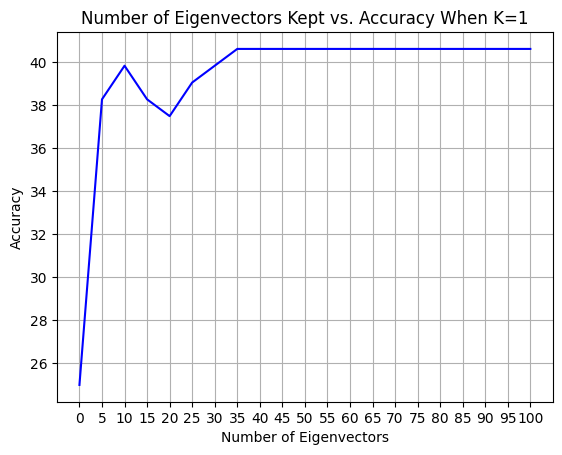

In [8]:
'''Explore how the number of eigenvectors kept affect the accuracy'''
ns = np.array(range(0,101,5))
accuracies = []
k=1
k_fold=7
for n in ns:
  mean_face, selected_eigenvectors, _, _ = PCA(np.array(animal_train_images), n)
  train_features = extract_eigenface_features(np.array(animal_train_images), mean_face, selected_eigenvectors)
  test_features = extract_eigenface_features(np.array(animal_test_images), mean_face, selected_eigenvectors)
  accuracies.append(train_and_test(train_features, animal_train_label, test_features, animal_test_label,k,k_fold))

plt.plot(ns, accuracies, color="Blue")
plt.xlabel("Number of Eigenvectors")
plt.ylabel("Accuracy")
plt.xticks(ns)
plt.title(f"Number of Eigenvectors Kept vs. Accuracy When K={k}")
plt.grid()
plt.show()

3 [42.96875, 34.375, 35.9375, 35.9375, 35.9375, 35.9375, 32.8125, 32.03125, 29.6875, 29.6875]


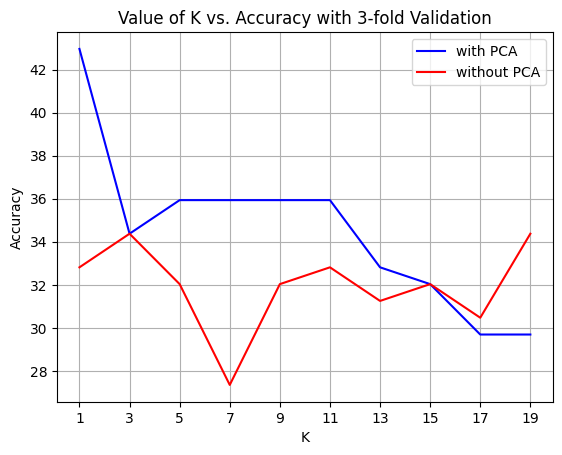

5 [40.625, 39.0625, 47.65625, 42.96875, 39.0625, 39.0625, 35.9375, 35.9375, 35.9375, 32.03125]


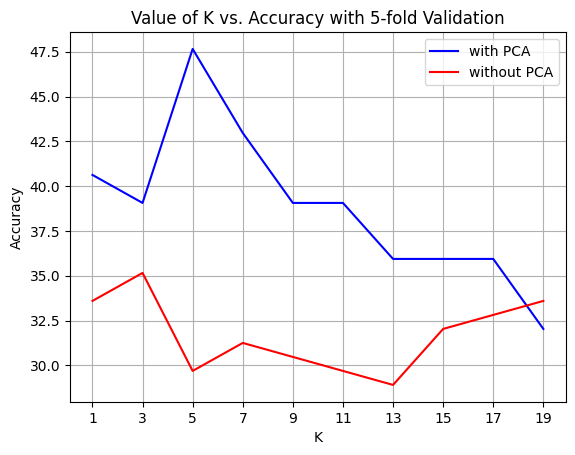

7 [40.625, 42.96875, 44.53125, 43.75, 42.1875, 39.0625, 37.5, 34.375, 34.375, 33.59375]


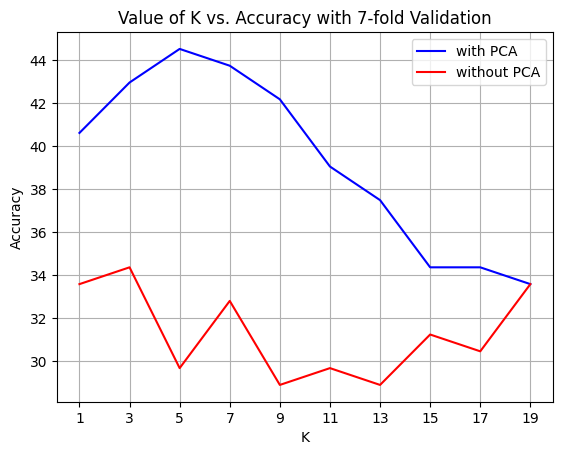

9 [40.625, 42.96875, 45.3125, 43.75, 39.84375, 37.5, 39.0625, 37.5, 33.59375, 35.15625]


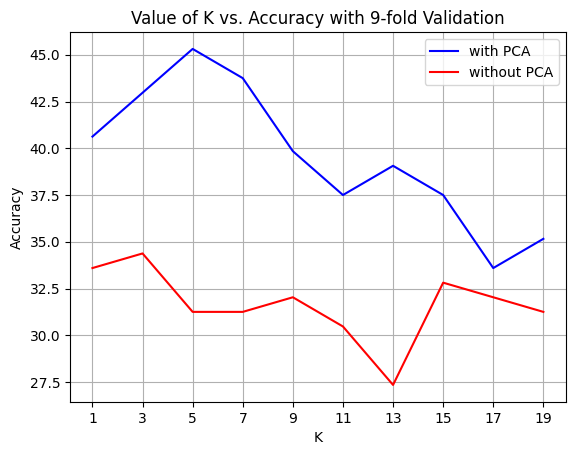

11 [40.625, 42.96875, 46.09375, 43.75, 40.625, 40.625, 39.84375, 35.9375, 35.15625, 34.375]


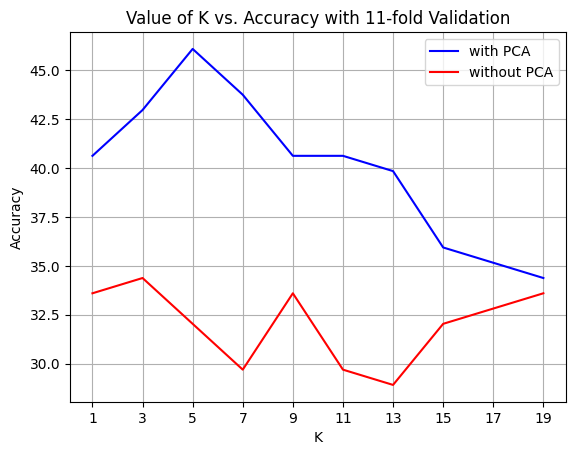

13 [40.625, 42.96875, 45.3125, 44.53125, 39.84375, 41.40625, 39.84375, 38.28125, 34.375, 34.375]


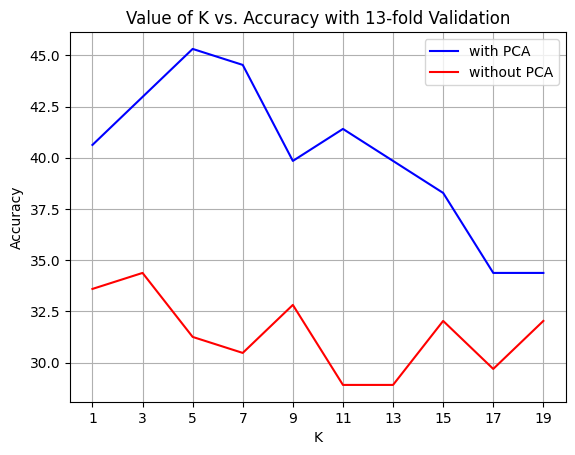

In [9]:
# Investigate how accracy changes with value of K
temp_train_set = np.array(animal_train_images)
temp_train_set = temp_train_set.reshape(temp_train_set.shape[0],-1)
temp_test_set = np.array(animal_test_images)
temp_test_set = temp_test_set.reshape(temp_test_set.shape[0],-1)

for j in range(1,7):
  k_fold = 2*j+1
  accuracies_pca = []
  accuracies = []
  Ks = []
  for i in range(10):
    k = 2*i+1
    Ks.append(k)
    accuracies_pca.append(train_and_test(train_features, animal_train_label, test_features,animal_test_label,k,k_fold))
    accuracies.append(train_and_test(temp_train_set, animal_train_label, temp_test_set, animal_test_label,k,k_fold))

  print(k_fold, accuracies_pca)
  plt.plot(Ks, accuracies_pca, color="Blue")
  plt.plot(Ks, accuracies, color="Red")
  plt.xlabel("K")
  plt.ylabel("Accuracy")
  plt.xticks(Ks)
  plt.title(f'Value of K vs. Accuracy with {k_fold}-fold Validation')
  plt.grid()
  plt.legend(["with PCA", "without PCA"])
  plt.show()